# Data Mining For Networks Project
#### Realized by Ladisa Piergiorgio & Nicola Sebastianelli

## Project Desctiption:
Different types of attacks exist in a network, e.g. port scan, denial of services, botnets. There are two main ways to prevent them. The first one is to try to detect explicitely a virus in the payload of packets. The second one is to detect anomalous patterns of communication.
The goal of the project is to develop a method to carry out anomaly detection in IP traffic. In few words, the principle of the method is to build a profile of each IP address under the form of a small graph, called graphlet. We then build a model using Support Vector Machine to distinguish normal from malicious end hosts from an annotated trace. The last step will be to try to detect attack in a not annotated trace.

## 0) Libraries:
For the realization of this project we are going to use some libraries that will help us to achieve the detection of the anomal traffic, the following libraries are **required** in order to execute the code, the main used libraries are Networkx and Scikit-Learn

* **Numpy**:Scientific computing.
* **MatplotLib**: 2-D plotting library.
* **Pandas**: Data structures and data analysis.
* **Seaborn**: Statistical data visualization.
* **Math**: Mathematical functions.
* **Networkx**: Creation, manipulation, and study of the structure, dynamics, and functions of complex networks.
* **Graphviz layout/pygraphviz**: Plotting of Networkx graphs.
* **Scipy**: Scientific computing and technical computing.
* **SkLearn**: Simple and efficient tools for data mining and data analysis.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import time 
from scipy.sparse import lil_matrix, kron,identity
from sklearn.model_selection import  train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from scipy.sparse.linalg import lsqr
from sklearn import svm, datasets

## 1) Papers:
In order to implement this project the study, analysis and revision of some paper is required:
* **[Profiling the end host](https://www.researchgate.net/publication/220850186_Profiling_the_End_Host)**: Undestand the graphlet structure used to detect anomalies.
* **[Fast Random Walk Graph Kernel](http://team-net-work.org/pdfs/KangTS_SDM12.pdf)**: Build the random walk kernel. trick
* **[Shortest-path kernels on graphs](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.411.7965&rep=rep1&type=pdf)**: Build the shortest path kernel.

## 2) End-Host profile using graphlet

In the paper [Profiling the end host](https://www.researchgate.net/publication/220850186_Profiling_the_End_Host) the authors propose a new way to profile the end-hosts. What the authors noticed is that the profiles of end-hosts can be very different, this can be so a good metrics for security analysis, diagnosis and classification. In a short time (e.g., 15 minutes), the profile of a end-host change slow, for this reason the authors belives that graphlets could be an interesting approach for host profiling.


A graphlet is a graph expressed by 6 main type of **graphlet node**: srcIP, protocol, dstIP, srcport, dstport, dstIP. The addition of and extra dstIPis important to our methodology. The **graphlet edges** instead means that there exists at least one ﬂow whose packets contain the speciﬁc nodes.This way, each ﬂow creates a directed **graphlet path** starting from the host IPaddress on the left and traversing the appropriate entities in each column. Notethat we deﬁne a ﬂow by the 5-tuple of the packet header, and the ﬂow can consistof one or more packets. Similarly, a graphlet path can correspond to a multitude of ﬂows with the same 5-tuple deﬁnition. This redundancy is critical, since itallows us to observe all pairwise interactions between the most information-heavyﬁelds of the 5-tuple: destination IP address (dstIP ), the source port (srcport)and destination port (dstport).If many ﬂows traverse a node, the node will most likely have a high degree. Byconstruction, all edges in a graphlet are between nodes of adjacent columns. Ifwe traverse a graphlet from left to right by following a path, we deﬁne a directionin visiting the nodes

## 3) Build a simple graphlet

In the following part we are going to create and visualize a simple graphlet using some detected traffic entries, the use of pandas library will help us to manage the data. In this part we are also going to declaire some function that will be usefull for us for the rest of the project.

In [2]:
#Build structure containing the data we want to analyse
d = {'srcIP': ["12.124.65.34","12.124.65.35","12.124.65.35","12.124.65.36"],
     'dstIP': ["12.124.65.33","12.124.65.37","12.124.65.36","12.124.65.37"],
     'protocol': ["17","17","6","6"],'sPort': ["138","80","167","443"],
     'dPort': ["138","80","80","443"],'activity': ["normal","normal","anomaly","anomaly"]}
#Build dataset from the defined structure
dfClassified = pd.DataFrame(data=d)
dfClassified

,activity,dPort,dstIP,protocol,sPort,srcIP
0,normal,138,12.124.65.33,17,138,12.124.65.34
1,normal,80,12.124.65.37,17,80,12.124.65.35
2,anomaly,80,12.124.65.36,6,167,12.124.65.35
3,anomaly,443,12.124.65.37,6,443,12.124.65.36


In [3]:
# Given in input a dataframe containing only entries from a specific srcIP, 
# this function return an array containing ALL the edges of a graphlet distingued by 
# srcIP,protocol,dstIP,sPort,dPort,dstIP

def graphletEdges(df):
    E=[]
    for index, row in df.iterrows():
        E.append((row["srcIP"], row["protocol"]+" "))
        E.append((row["protocol"]+" ", " "+row["dstIP"]))
        E.append((" "+row["dstIP"], " "+row["sPort"]+" "))
        E.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
        E.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    return E

In [4]:
# Create a single graphlet indicating the srcIP of the graphlet
def computeGraphlet(src,df):
    G = nx.DiGraph()
    G.add_edges_from(graphletEdges(df[df.srcIP==src])) # Taking advantage of the previously defined function
    return G

In [5]:
# Given in input a dataframe containing only entries from a specific srcIP, 
# this function return an array containing JUST anomal edges of a graphlet distingued by 
# srcIP,protocol,dstIP,sPort,dPort,dstIP
#
# This function is used just for visualization reasons.
def anomalGraphletEdges(df):
    anomalE=[]
    for index, row in df.iterrows():
        if row["activity"] =="anomaly":
            anomalE.append((row["srcIP"], row["protocol"]+" "))
            anomalE.append((row["protocol"]+" ", " "+row["dstIP"]))
            anomalE.append((" "+row["dstIP"], " "+row["sPort"]+" "))
            anomalE.append((" "+row["sPort"]+" ", "  "+row["dPort"]+"  "))
            anomalE.append(("  "+row["dPort"]+"  ", "  "+row["dstIP"]))  
    return anomalE

In [6]:
# Plot of a single graphlet giving in input the srcIP of the specific graphlet and the dataset
def plotGraflet(src,df):
    G=computeGraphlet(src,df) # Building graphlet of the srcIP
    anomalE=anomalGraphletEdges(df[df.srcIP==src]) # Finding anomal edges
    pos = graphviz_layout(G, prog='dot') # Perfect plot layout for graph visualization 
    nx.draw(G,pos,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9) # Graph plot
    nx.draw_networkx_edges(G, pos, edgelist=anomalE,width=8, alpha=0.4, edge_color='r') # Anomal edges plot
    plt.show()

In [7]:
# Plot of every graphlet contained in a given data set
def plotMultipleGraflet(df):
    for i in range(len(df.srcIP.unique())):
        fig= plt.figure(figsize=(7, 7)) # Create a new figure for the every single graphlet 
        plotGraflet(df.srcIP.unique()[i],df) # Plot the graphlet with specific srcIP


In [8]:
# Creation of sub-set of the complete dataset containing the flow of just specific sources
def dfFromSources(srcArray,df):
    dfArray=[]
    for i in srcArray:
        dfArray.append(df[df.srcIP==i])
    return pd.concat(dfArray)

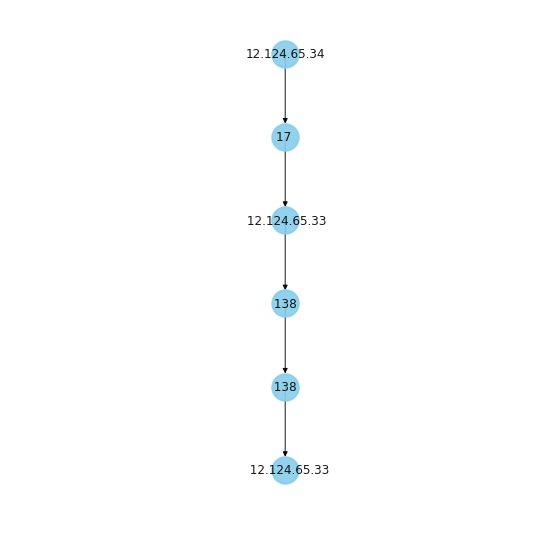

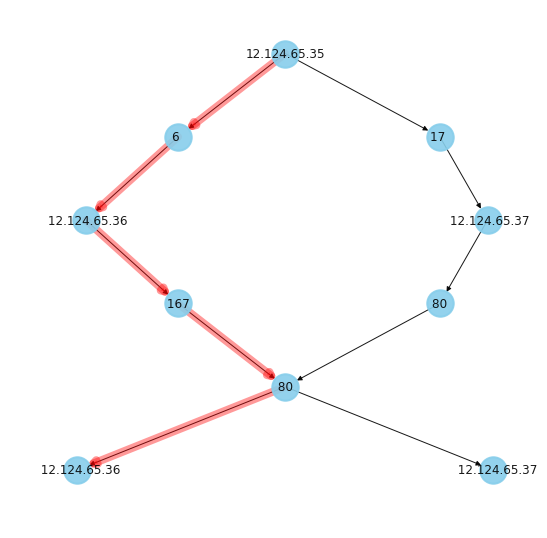

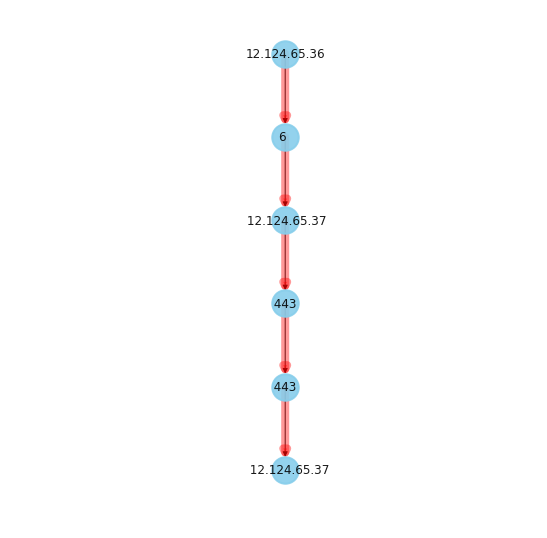

In [9]:
# Visualization of simple graphlet
plotMultipleGraflet(dfClassified)

## 4) Build the flow dataset 
In this section we are going to build and analyse the dataset on which we will tai our model.

In [10]:
dfClassified = pd.read_csv('annotated-trace.csv').astype(str) # Upload dataset from file 
dfClassified

,srcIP,dstIP,protocol,sPort,dPort,activity
0,214,776,17,21,79,normal
1,933,79,6,21,80,normal
2,139,243,17,53,80,normal
3,920,198,6,80,21,normal
4,100,174,17,20,21,normal
5,756,435,17,80,79,normal
6,669,409,6,53,80,normal
7,518,57,6,68,23,normal
8,785,389,17,22,68,normal
9,485,657,17,25,21,normal


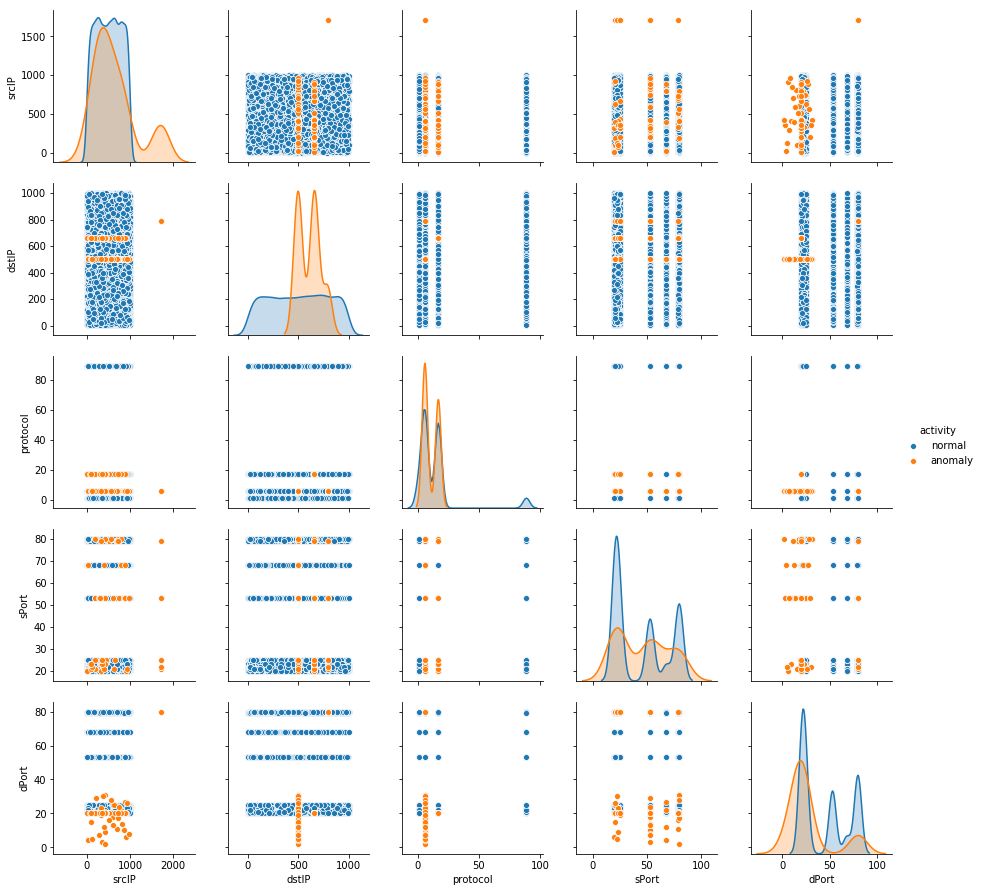

In [11]:
# Plot of scatter for each pair of feature to study the data pattern of anomalies
sns.pairplot(dfClassified, kind="scatter", hue="activity")
plt.show()

What we can see from the previous graph is that anomalies are concentated the most on few specific port, protocol and destinations.

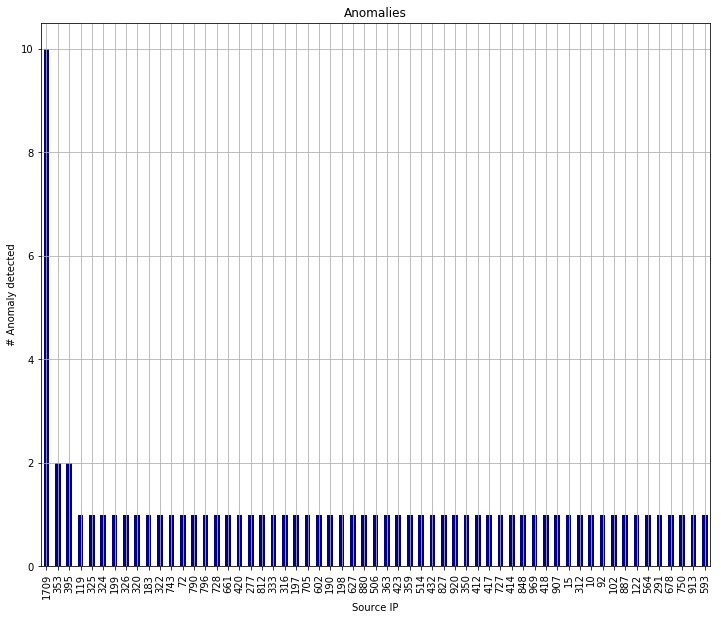

In [12]:
# Plotting the srcIP of the detected anomalies 
dfClassified[dfClassified.activity=="anomaly"]
ax = dfClassified[dfClassified.activity=="anomaly"].srcIP.value_counts().plot(kind="bar", figsize=(12, 10),colormap='jet',title='Anomalies',grid=True)
ax.set_xlabel("Source IP")
ax.set_ylabel("# Anomaly detected")

From this graph we can see that in most of the cases the graphlets has one anomaly except fot the graphlet with srcIP: 395,353,1709.

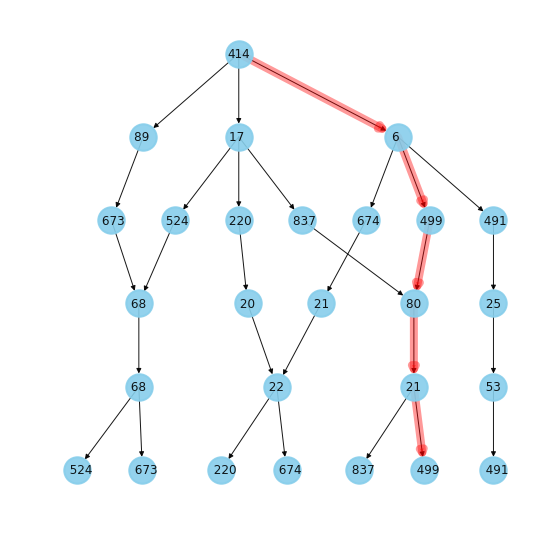

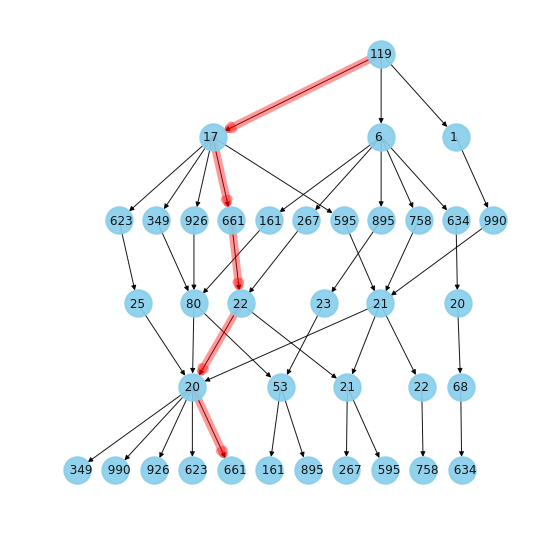

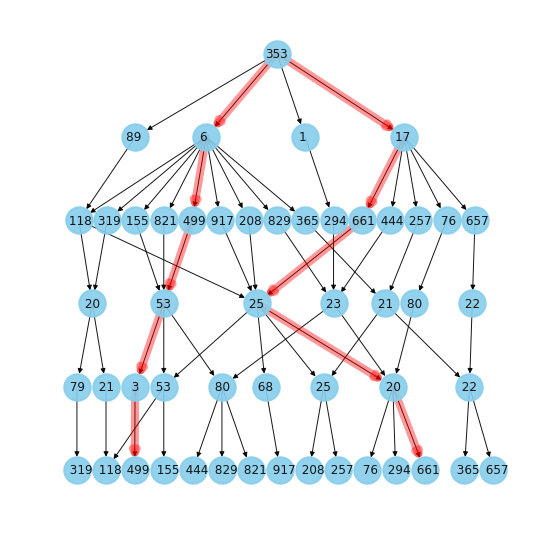

In [13]:
# Plot of some graphlet contained in the dataset
sources = ["414","119","353"]
plotMultipleGraflet(dfFromSources(sources,dfClassified))

## 5) Building of all the graghlet in the dataset

In [14]:
# Building the array of graphlets from a dataset
def allGraphlets(df):
    graphlets = []
    srcIP = list(df.srcIP.unique())
    for i in range(len(srcIP)):
        graphlets.append(computeGraphlet(srcIP[i],df))
    return graphlets

# Random Walk

## 6) Transform the graphlet to high dimentional space of the random walk kernel

The random walk kernel will be used to perform classification on graphlet. The random walk kernel counts how many walks of different length can be done in a graph G. The number of walks of a specified length can be computed using the adjacency matrix: $A^k$  with k = walk length.

Example:

$$
A=
\left(\begin{array}{cc} 
0 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 0\\
\end{array}\right)
$$ 

$$
A^2=
\left(\begin{array}{cc} 
0 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 0\\
\end{array}\right)
\left(\begin{array}{cc} 
0 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 0\\
\end{array}\right)
=
\left(\begin{array}{cc} 
2 & 1 & 1\\
1 & 2 & 1\\
1 & 1 & 2\\
\end{array}\right)
$$


The feature values are given by the number of walks between every pair of vertices, The random walk kernel cosider the sum over all length of walks, so the feature values are given by $\sum_{k=0}^{n} A^k$ so if for example we compute it for length 4 we will obtain:

$$
A_f=A^0+A^1+A^2+A^3+A^4=
\left(\begin{array}{cc} 
1 & 0 & 0\\
0 & 1 & 0\\
0 & 0 & 1\\
\end{array}\right)
+
\left(\begin{array}{cc} 
0 & 1 & 1\\
1 & 0 & 1\\
1 & 1 & 0\\
\end{array}\right)
+
\left(\begin{array}{cc} 
2 & 1 & 1\\
1 & 2 & 1\\
1 & 1 & 2\\
\end{array}\right)
+
\left(\begin{array}{cc} 
2 & 3 & 3\\
3 & 2 & 3\\
3 & 3 & 2\\
\end{array}\right)
+
\left(\begin{array}{cc} 
6 & 5 & 5\\
5 & 6 & 5\\
5 & 5 & 6\\
\end{array}\right)
=
\left(\begin{array}{cc} 
11 & 10 & 10\\
10 & 11 & 10\\
10 & 10 & 11\\
\end{array}\right)
$$

In this example the feature values are 9 for this graph. Another point to consider is the fact that the SVM of scikit-learn accept as input a matrix of features, for this reason we need to flat our adjacency matrix into a vector, taking into account the above example we will have:
$$
flat(A_f)= \left(\begin{array}{cc} 
11 & 10 & 10 & 10 & 11 & 10 & 10 & 10 & 11 &
\end{array}\right)
$$

In [15]:
# Check if a graphlet contains anomalies
def hasAnomalies(src,df):
    graph=df[df.srcIP==src]
    return len(graph[graph.activity=="anomaly"]) != 0

hasAnomalies("414",dfClassified) # Test

True

In [16]:
# Function used for computing the feature vector, it is based on the adjacency matrix of a graphlet and walk lenght
def computeFeatureVector(walkLength,graphlet):
    # Create the adjacency matrix of a graphlet 
    a=nx.adjacency_matrix(graphlet,nodelist=sorted(graphlet.nodes())).todense() 
    i=np.identity(a.shape[0], dtype = int ) # Identity matrix of the same size of the adjacency matrix
    b=a # 1 walk adjacency matrix
    res=i+a
    for i in range(1,walkLength):
        a=np.dot(a,b) # Dot product of A^i and A
        res+=a
    return np.squeeze(np.asarray(res)).flatten() # Flat of the adjacency matrix

[11 10 10 10 11 10 10 10 11]


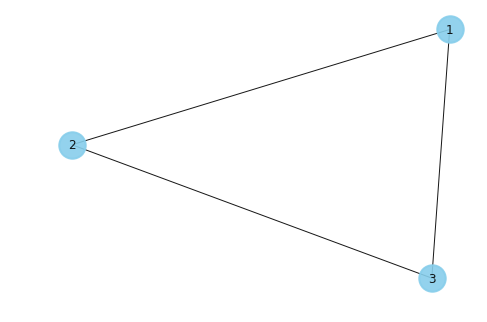

In [17]:
# Execution of the above example
G = nx.Graph()
G.add_edges_from([(1,2),(2,3),(3,1)])
nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
print computeFeatureVector(4,G)

We are now going to transform the graphlet into high dimensional space of the random walk kernel, for doing so we have to take into account two important aspect:
1. The fact that the scikit-learn svm allow as input only vector with same dimensions, this is a problem for us because we feature vectors (flatten adjacency matrices) can be of different length since the graphlet could have different number of nodes. A solution for this problem could be padding with zeros the smaller feature vector such that every feature vector will have same length  
2. How to consider the anomalies, since we have to classify the graphlets, we decided that if a graphlet has anomal flows inside the entire graphlet will be considered anomal.

In [18]:
# Transform all the graphlet into high dimensional space of the random walk kernel with length 4
def allFeatures(df,pad):
    Y=[]
    graphlets = allGraphlets(df)
    features = [] # Feature vector
    maxlen=0 # Biggest feature vector length
    srcIP = list(df.srcIP.unique()) # List of all srcIP in the dataset
    for i in range(len(srcIP)): # Compute feature vector for every graphlet
        features.append(computeFeatureVector(4,graphlets[i]))
        if (len(features[i]) > maxlen): # Save the biggest feature vector length
                maxlen=len(features[i]) 
        if (hasAnomalies(srcIP[i],df)): # Check if a graphlet contain anomalies for labeling it
            Y.append("anomaly")
        else:
            Y.append("normal")
    # Padding with specific value all the feature vector
    for i in range(len(srcIP)):
        features[i] = np.pad(features[i], (0,maxlen-features[i].size), 'constant', constant_values=(pad))
    return features, Y, maxlen

features, Y, maxlen= allFeatures(dfClassified,0)

## 7) Build model with SVM

For building the model we are going to use the feature vector (flatten adjacency matrix) and the label vector(normal or anomaly), first of all we will create our model using a SVC because we are working with a classifier with a linear kernel. To check if we are working in the correct way we decided to split the data into train and test and then create a confusion matrix. Note that the obtained results of this testing phase can't be taken too much into account because we are training with really few entries (1001 graphlet in total) and if we exclude some anomal entry in the training phase because they are in test subset the accuracy of our model can be completely different. To avoid this problem and obtain a more realiable analysis we should have way more graphlets to analyze.

In [19]:
# Splitting feature vector and label vector in training and test  
X_train, X_test, y_train, y_test = train_test_split(features, Y, test_size=0.2,random_state=0)
clf = svm.SVC(gamma='auto',kernel='poly')
clf.fit(X_train, y_train)
print "Size of training set: ",len(X_train)
print "Size of testing set: ",len(X_test)

Size of training set:  800
Size of testing set:  201


In [20]:
time_start = time.clock()
y_pred= clf.predict(X_test) # Using test feature vector for check the accuracy
time_elapsed = (time.clock() - time_start)
print "Computation time: ", time_elapsed,"s"
print accuracy_score(y_test,y_pred) # Comparing the predicted label with the real ones

Computation time:  0.225156 s
0.9353233830845771


              precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00        13
      normal       0.94      1.00      0.97       188

   micro avg       0.94      0.94      0.94       201
   macro avg       0.47      0.50      0.48       201
weighted avg       0.87      0.94      0.90       201



/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


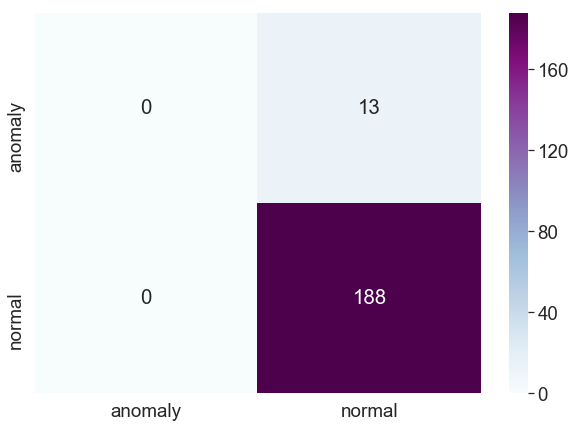

In [21]:
print classification_report(y_test, y_pred) # Printing the accuracy comparing the true labels with the predicted ones for each labe

# Creating the confusion matrix 
cm=confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu",xticklabels=["anomaly","normal"], yticklabels=["anomaly","normal"] )

In [22]:
# Training the model without splitting in training and test
clf1 = svm.SVC(gamma='auto',kernel='linear')
clf1.fit(features, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Random Walk Kernel Trick

## 8) Build kernel trick
To avoid the mapping of the graphlets in the high dimensional space, we are going to use a kernel trick. This method is based on the work of the paper: **[Fast Random Walk Graph Kernel](http://team-net-work.org/pdfs/KangTS_SDM12.pdf)** and the slides [Graph kernel](https://www.cs.ucsb.edu/~xyan/tutorial/GraphKernels.pdf) & [GRAPH MINING AND GRAPH KERNELS](https://www.cs.ucsb.edu/~xyan/tutorial/KDD08_graph_partII.pdf).

This method is used to find a common walk in to graphs thanks to the direct product graph (tensor product) property.
The direct product graph is defined as the direct product G x H of the  graphs G and H such that V(G x H) is the cartesian product of V(G) x V(H). In G x H the vertices (u,u') and (v,v') ∈ V(G,H) are adjacent iff u is adjacent of v in G and u' is adjacent to v' in H.

Let G1 and G2 be two graphs, let $A_x$ denote the adjacency matrix of their product graph $G_x$, and $V_x$ the vertex set of the product graph.

The random walk kernel trick is defined as:
$$
k_x(G_1,G_2)=\sum_{i,j=1}^{|V_x|}[\sum_{n=0}^{\infty}\lambda^n A^n_x]_{ij} = e^T (I-\lambda A_x)^{-1} e
$$
Where I is the identity matrix, e is the a ones vector, and $\lambda$ is the fading factor such that $|\lambda|<1$. The random walk kernel converges only if $\lambda< \frac{1}{\lambda_x}$ where \lambda_x is the largest eigenvalue of $A_x$. 

The complexity of this method is $O(n^6)$ due to the computation of the product graph and inversion of the adjacency matrix.

To reduce the computation complexity we can take advantage of the vectorization of a matrix and the Kronecker product due to the fact that the adjacency matrix of the direct product is the Kronecker product of the adjacency matrix of the graph $G_1$ and $G_2$ such that being $⊗$ the Kronecker product we will have $A_x=A(G_1)⊗A(G_2)$

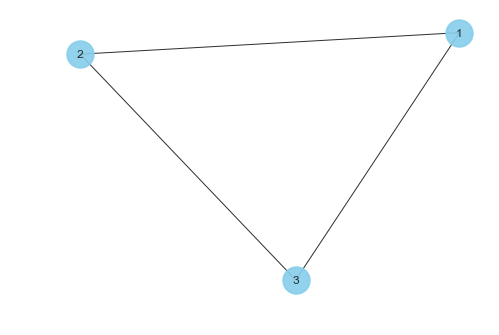

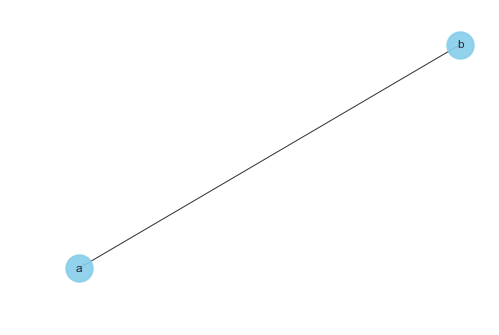

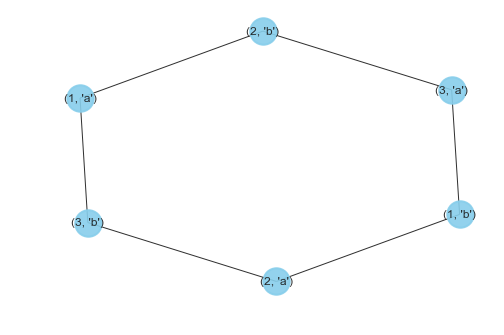

In [23]:
# Reproducing the class example of the direct product graph
G1 = nx.Graph()
G1.add_edges_from([(1,2),(2,3),(1,3)])
G2 = nx.Graph()
G2.add_edges_from([('a','b')])
plt.figure(1)
nx.draw(G1,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
plt.figure(2)
nx.draw(G2,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)
plt.figure(3)
G=nx.tensor_product(G1, G2) # Direct product graph
nx.draw(G,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9)

##### We are now going to have a comparison between computing the kernel trick using the tensor product of graphlet and Kronecker product of the adjacency matrix. As we can see both methods produces same kernel value and adjacency matrix prooving that the two methods produces same results.

In [24]:
# Creating the random kernel trick that take as input two graphs
def randomWalkKernelTrick(G, H):
    LAMBDA = 0.1
    productGraph = nx.tensor_product(G,H) # Tensor product of graphlet 
    a=nx.adjacency_matrix(productGraph,nodelist=sorted(productGraph.nodes())).todense()
    print a
    i=np.identity(a.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*a).sum() # Calculating kernel value
    return res

#Testing the kernel trick function with the previous two graphs G1 and G2
time_start = time.clock()
res=randomWalkKernelTrick(G1, G2)
time_elapsed = (time.clock() - time_start)
print "Kernel value: ",res
print "Computation time: ", time_elapsed,"s"

[[0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 0]]
Kernel value:  7.500000000000002
Computation time:  0.00373 s


In [25]:
# Creating the random kernel trick that take as input two adjacency matrices
def randomWalkKernelTrick(Ax, Ay):
    Az = np.kron(Ax,Ay) # Kronecker product of the adjacency matrices
    LAMBDA = 0.1
    print Az
    i=np.identity(Az.shape[0], dtype = int )
    res=np.linalg.inv(i-LAMBDA*Az).sum() # Calculating kernel value
    return res

# Execution
Ax=nx.adjacency_matrix(G1).todense()
Ay=nx.adjacency_matrix(G2).todense()
time_start = time.clock()
res=randomWalkKernelTrick(Ax, Ay)
time_elapsed = (time.clock() - time_start)
print "Kernel value: ",res
print "Computation time: ", time_elapsed,"s"

[[0 0 0 1 0 1]
 [0 0 1 0 1 0]
 [0 1 0 0 0 1]
 [1 0 0 0 1 0]
 [0 1 0 1 0 0]
 [1 0 1 0 0 0]]
Kernel value:  7.500000000000002
Computation time:  0.002254 s


Now that we have the basic function of the kernel trick we have to adapt it to be used as kernel of the SVM remembering that the adjacency matrices has to be transformed into feature vectors. For do so we decided to flatter the adjacency matrices and pad them with -1 (value that cannot appear in an adjacency matrix) and then inside the SVM we will transform the feature vectors back to adjacency matrices to perform.

In [26]:
def randomWalkKernelTrick(Ax, Ay):
    res = []
    for i in range(len(Ax)):
        temp=[]
        A1 = Ax[i][Ax[i] != -1] # Remove padding
        A1 = A1.reshape(int(math.sqrt(A1.size)),int(math.sqrt(A1.size))) # Resize into a matrix
        for j in range(len(Ay)):              
            A2 = Ay[j][Ay[j] != -1]  # Remove padding          
            A2 = A2.reshape(int(math.sqrt(A2.size)),int(math.sqrt(A2.size))) # Resize into a matrix
            Az = np.kron(A1,A2) # performing Kronecker product
            LAMBDA = 0.1
            i=np.identity(Az.shape[0], dtype = int )
            temp.append(np.linalg.inv(i-LAMBDA*Az).sum())
        res.append(temp)
        print "Iteration:",len(res)
    return res

In [27]:
# Computation of the features
features, Y, maxlen=allFeatures(dfClassified,-1)

In [28]:
# Fit phase done with few entries because too much expensive for my working machine
subsetSize= 30
clf2 = svm.SVC(gamma='auto',kernel=randomWalkKernelTrick)
clf2.fit(features[:subsetSize], Y[:subsetSize])

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel=<function randomWalkKernelTrick at 0x119939320>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [29]:
time_start = time.clock()
y_pred= clf2.predict(features[subsetSize:2*subsetSize])
time_elapsed = (time.clock() - time_start)
print "Computation time: ", time_elapsed,"s"

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Computation time:  386.997536 s


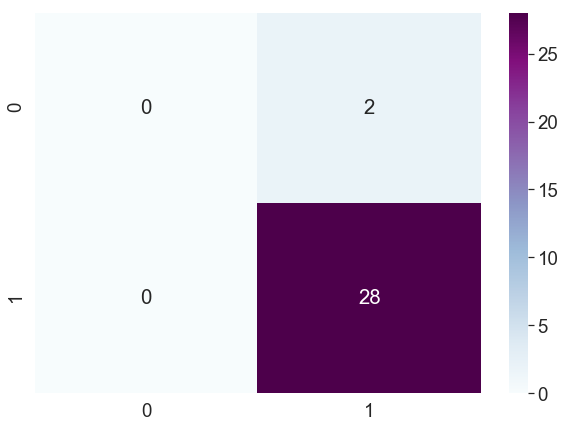

In [30]:
cm=confusion_matrix(Y[:subsetSize], y_pred,labels=['anomaly', 'normal'])
df_cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.7)
sns.heatmap(df_cm, annot=True, fmt='g',cmap="BuPu")

## 9) Apply models

In [31]:
featuresUnclassified = []
dfUnclassified = pd.read_csv('not-annotated-trace.csv').astype(str) # Load unclassified graph
graphlets= allGraphlets(dfUnclassified) # Obtaining all the graphlet
srcIP = list(dfUnclassified.srcIP.unique())
for i in range(len(srcIP)):
    featuresUnclassified.append(computeFeatureVector(4,graphlets[i])) # Building feature vector
for i in range(len(srcIP)):
    featuresUnclassified[i]=np.squeeze(np.resize(featuresUnclassified[i],(1,maxlen))) # padding with zeros

In [32]:
# Predicting without kernel trick
time_start = time.clock()
y_pred= clf1.predict(featuresUnclassified)
time_elapsed = (time.clock() - time_start)
print "Computation time: ", time_elapsed,"s"
predictions = pd.DataFrame({'srcIP':srcIP,'activity':y_pred})
predictions[predictions.activity=="anomaly"]

Computation time:  1.875395 s


,activity,srcIP
97,anomaly,274
132,anomaly,753
152,anomaly,612
174,anomaly,181
221,anomaly,780
271,anomaly,362
272,anomaly,93
283,anomaly,859
309,anomaly,485
381,anomaly,762


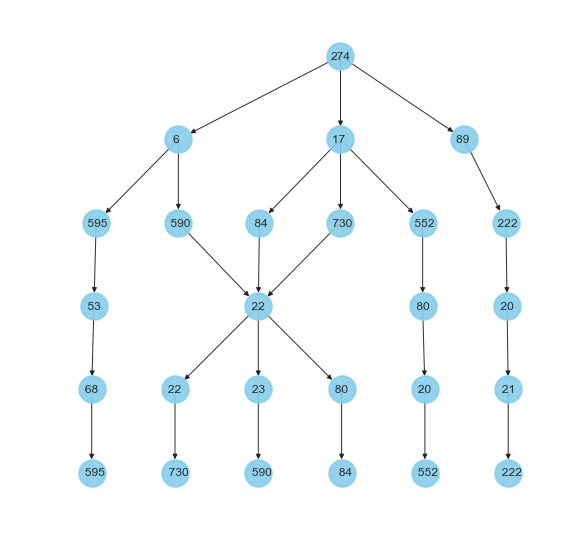

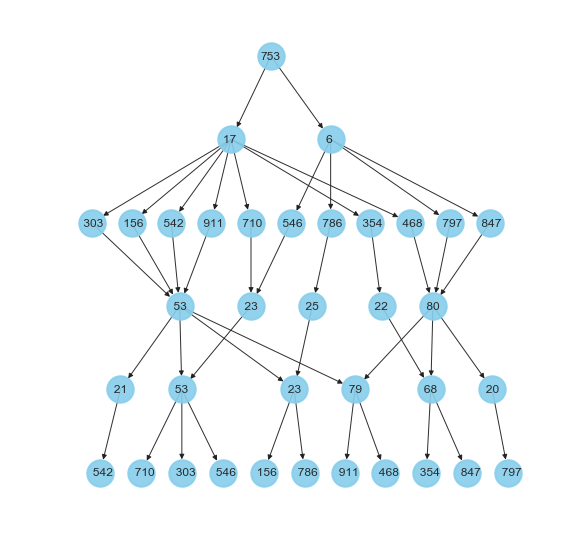

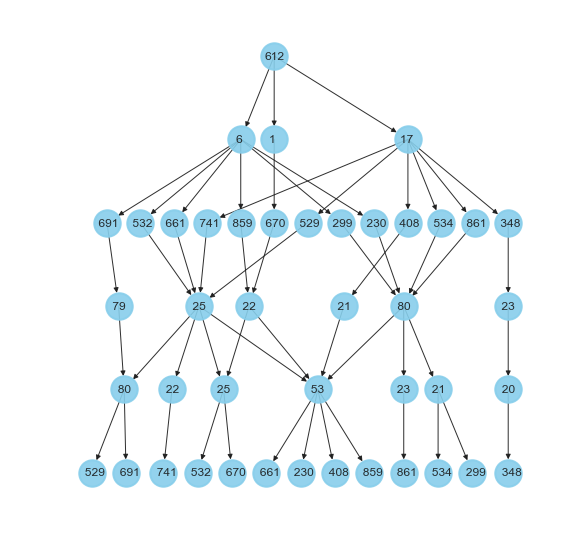

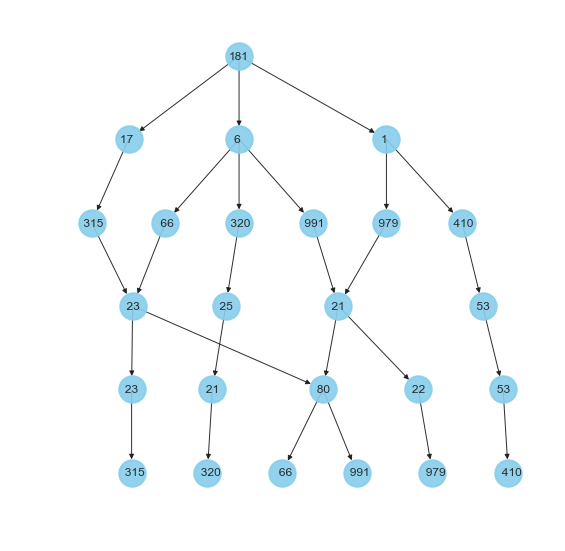

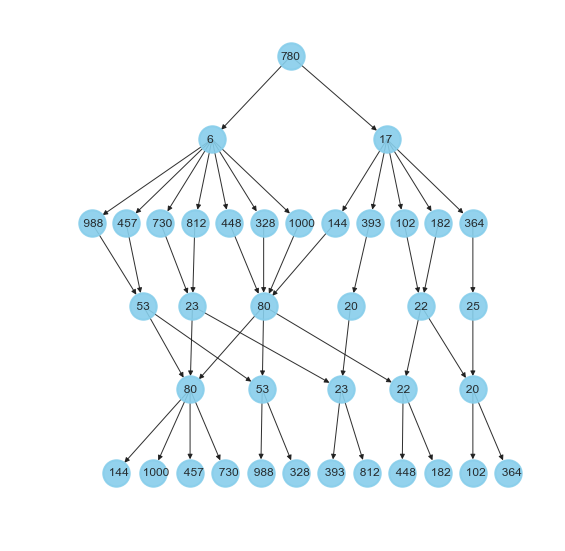

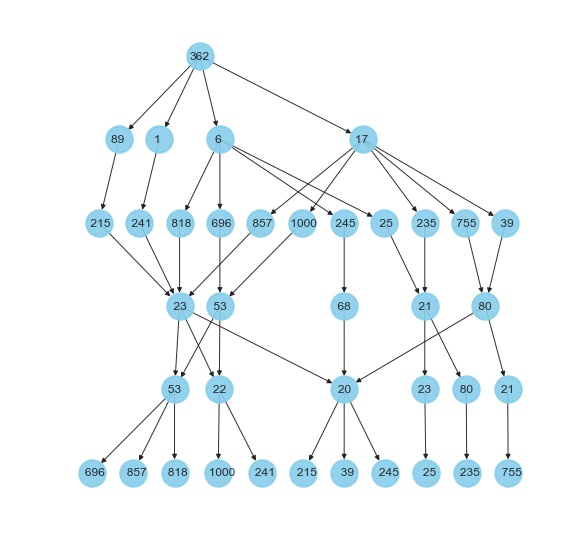

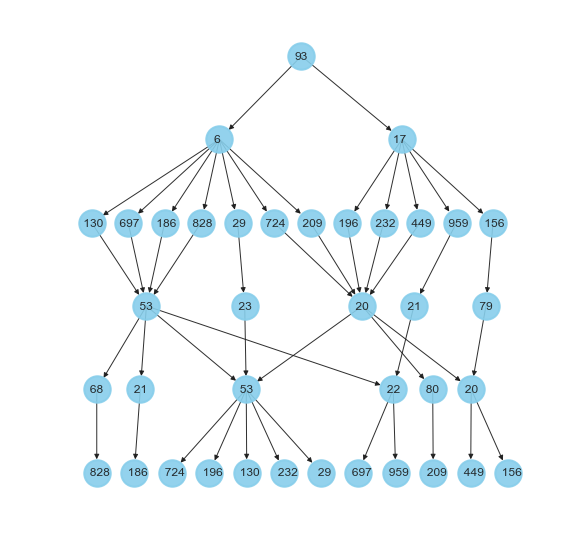

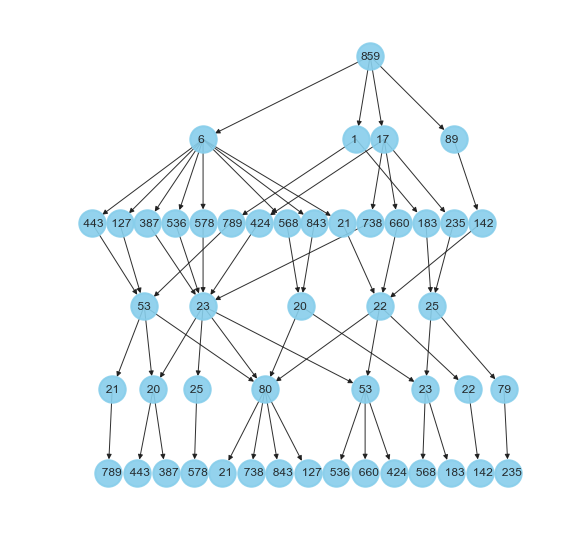

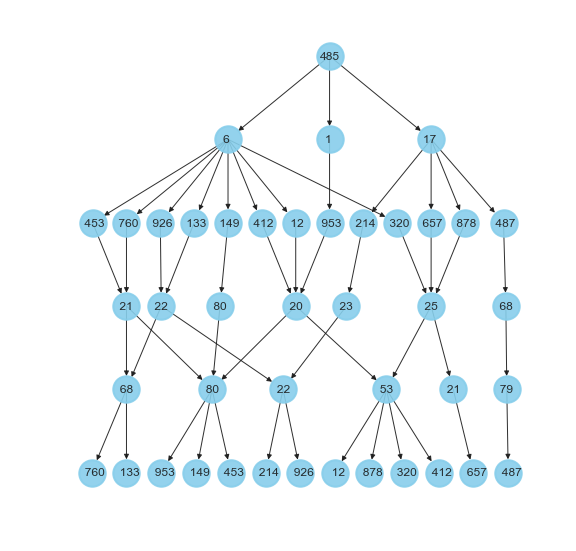

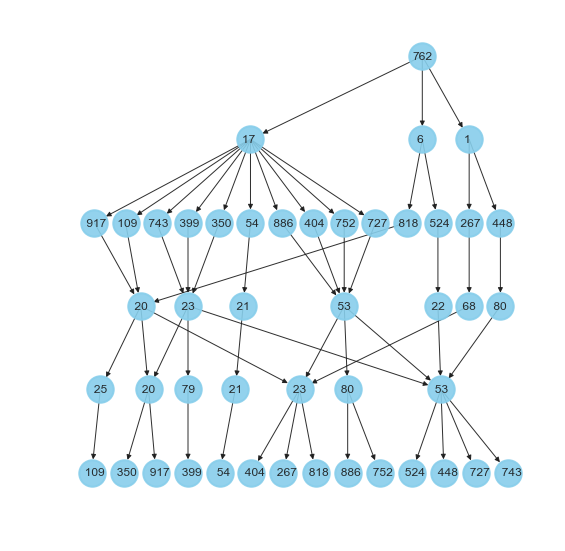

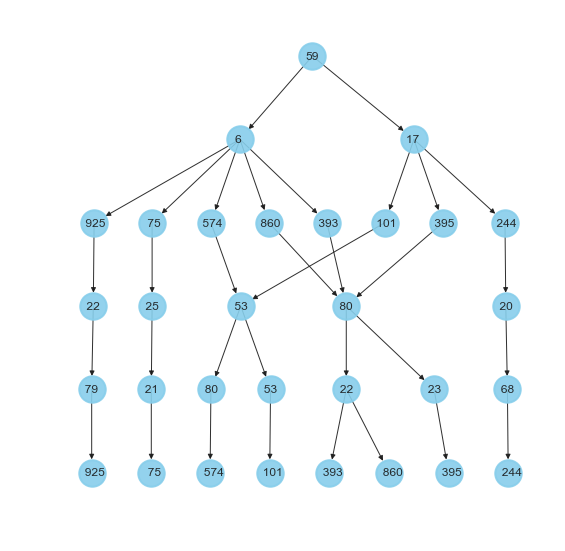

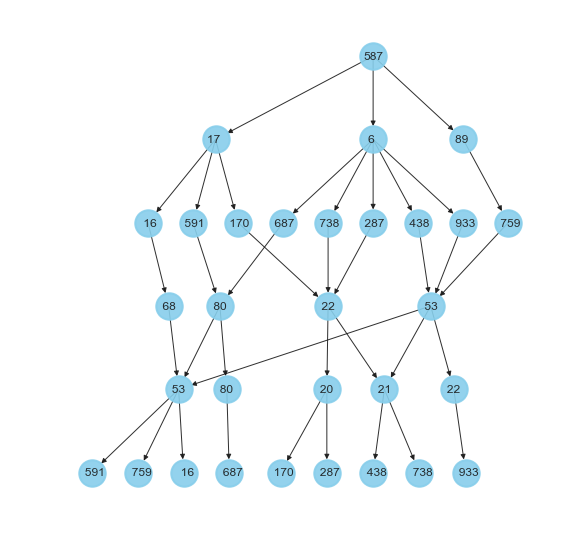

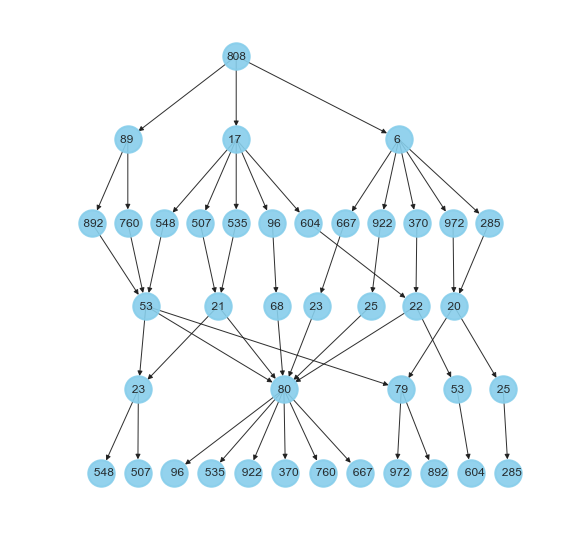

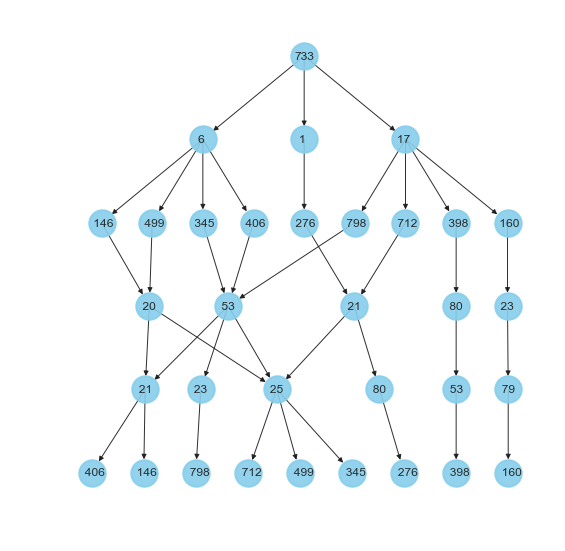

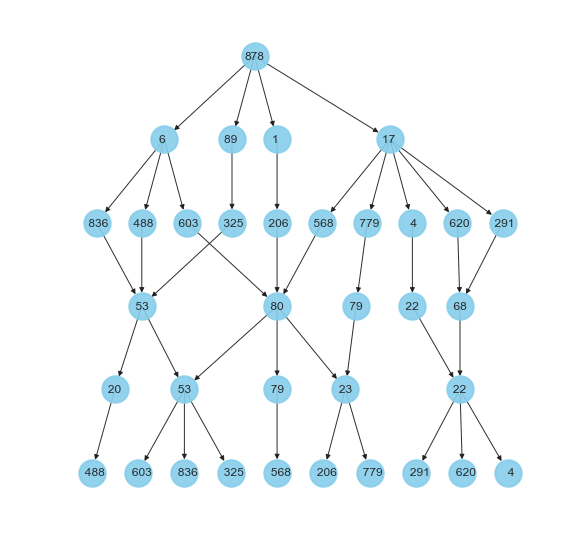

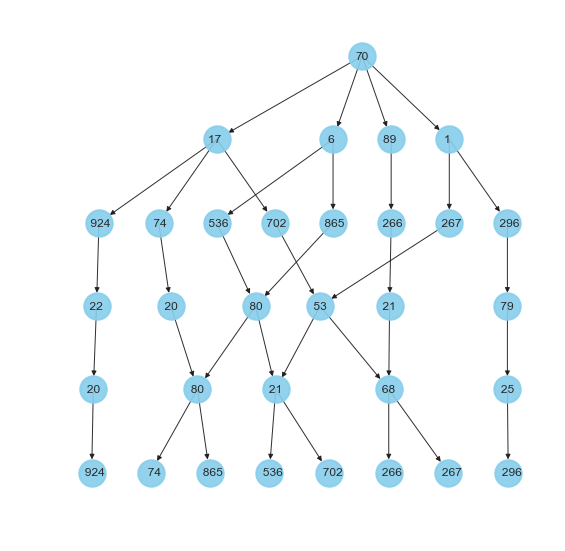

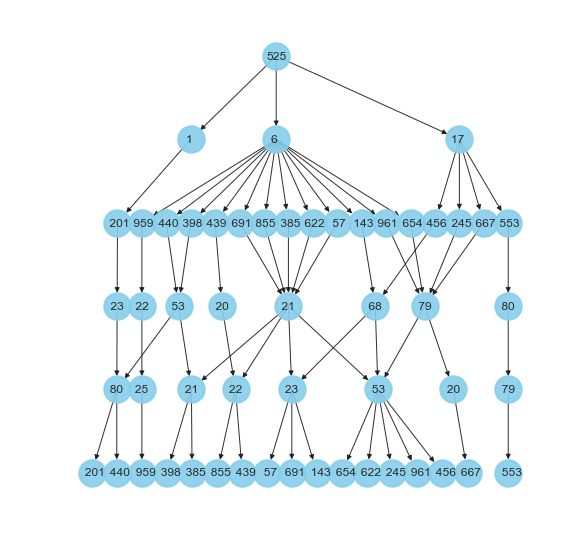

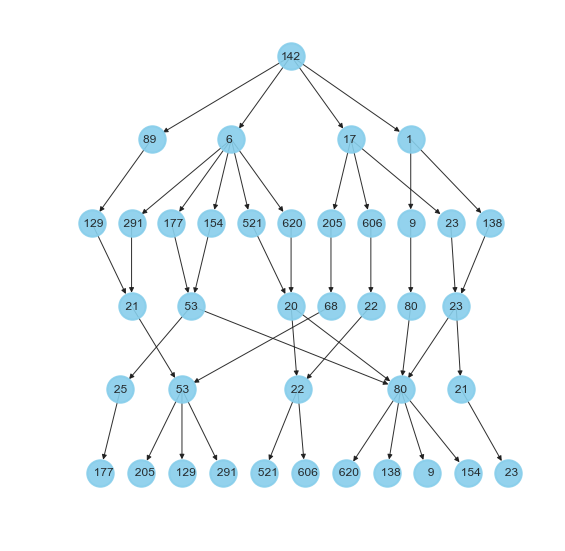

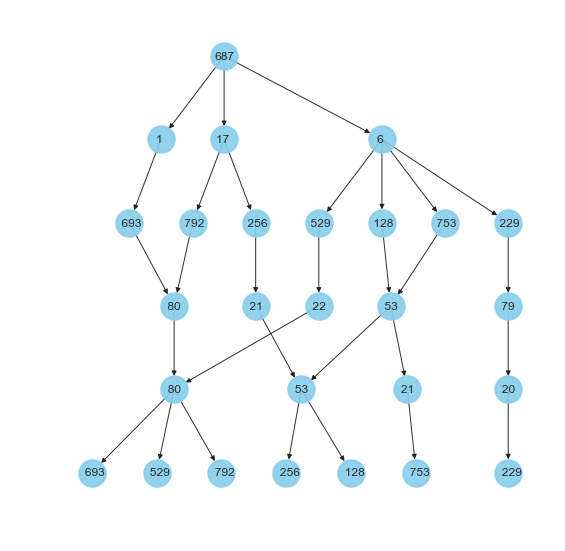

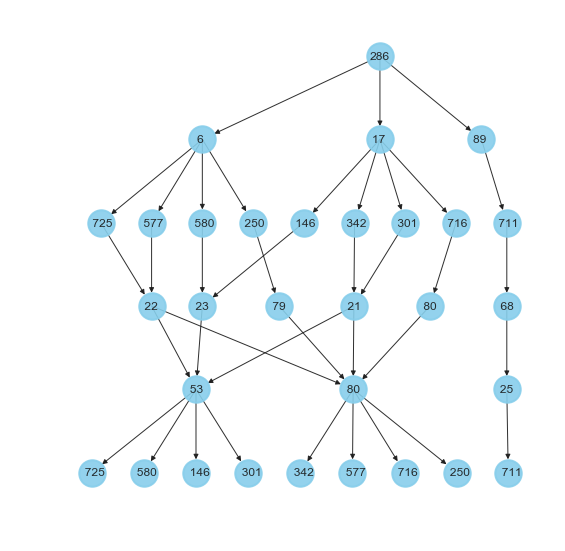

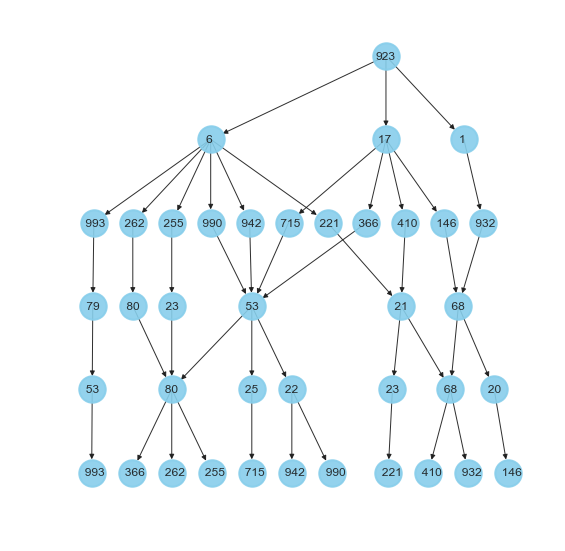

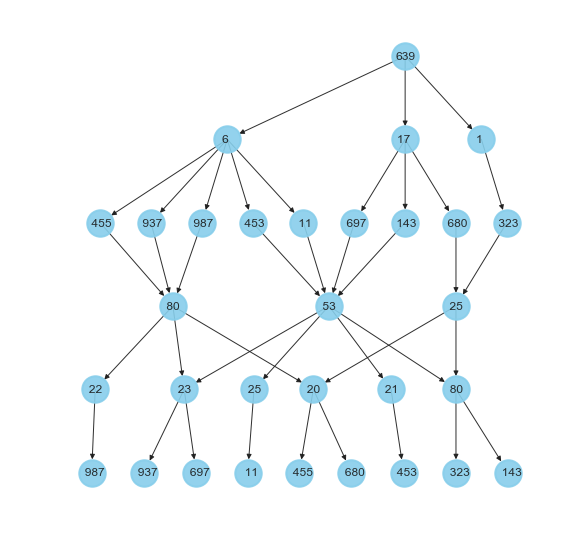

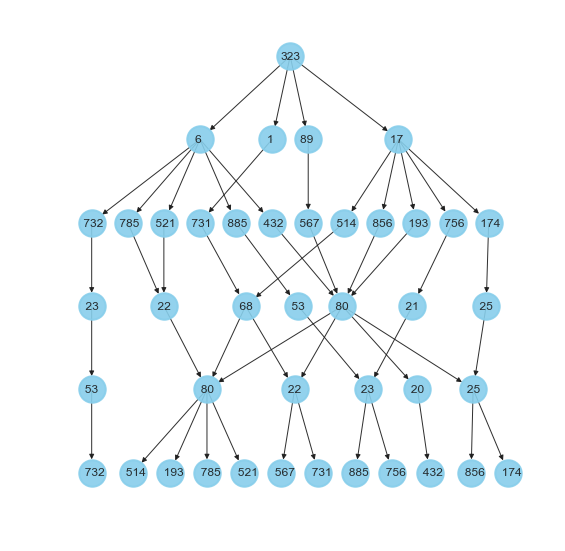

In [35]:
#Plot detected anomaly graphlet without kernel trick method
plotMultipleGraflet(dfFromSources(predictions[predictions.activity=="anomaly"]["srcIP"],dfClassified))

In [37]:
# Predicting with kernel trick, we are going to analyze few graphlet because computationally expensive
time_start = time.clock()
y_pred= clf2.predict(featuresUnclassified[:3])
time_elapsed = (time.clock() - time_start)
print "Computation time: ", time_elapsed,"s"
predictions = pd.DataFrame({'srcIP':srcIP[:3],'activity':y_pred})
predictions[predictions.activity=="anomaly"]

Iteration: 1
Iteration: 2
Iteration: 3
Computation time:  132.414861 s


,activity,srcIP
1,anomaly,799


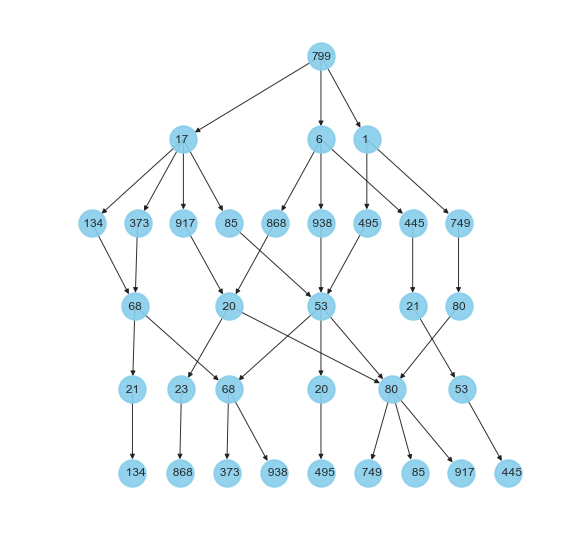

In [38]:
#Plot detected anomaly graphlet of kernel trick method
plotMultipleGraflet(dfFromSources(predictions[predictions.activity=="anomaly"]["srcIP"],dfClassified))

### Type of possible attacks:
What we can observe from the detected anomalous graphlet is that in many cases we have lot of different destination for one sigle source and that most of the flow use the protocol 17 (UDP) and less use the protocol 6 (TCP), this made us think about a botnet attack with the source as botmaster and the destination the zombies.

## 10) Potential false positives and false negatives
False positive anf false negative are two important aspect of the datamining. False positive is a type I error while false negative is a type II error. A false positive error means that the model incorrectly predict a positive class and false negative means that the model incorrectly predict a negative class.

Taking into account an example, supposing that we want to predict if a patient as cancer or not, a false positive is when our model predict that the patient has cancer but not in reality, while a false negative is when tha patient has the cancer but is not predicted. As we can imagine having false negative is way more dangereous for us. This example can be extended at our project, having a model that predict few anomalies than the actual ones is worst than one that predict more anomalies than the actual ones. For those reason is also important to analyse the confusion matrix of a model and apply techniques of cross validation.

# Shortest Path Kernel

## 11) Modeling and detection with Shortest Path Kernel
The following kernel is build following the paper **[Shortest-path kernels on graphs](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.411.7965&rep=rep1&type=pdf)**.

An essential part for performing the shortest-paths kernel is to transform the graphlet into a shortest-path graphlet using the Floyd-transformation. The transformed graph will contain the same amount of nodes but between every node there will be an edge having as weight the shortest distance between the two nodes.
The shortest path kernel is then computed as: $$K_{sp}(S_1,S_2)=\sum_{e1∈E_1}\sum_{e2∈E_2}k_{walk}^{(1)}(e1,e2)$$ where $S_1=(V_1,E_1)$ and $S_2=(V_2,E_2)$ are rispectevly the Floyd-transformation of $G_1$ and $G_2$ and $k_{walk}^{(1)}$ is a lenght 1 kernel walk performed using tensor product. This method has complexity: $O(n^3)$

For starting we are going to reprocuce the class example of Floyd-transformation. 

[[0 2 5 7]
 [2 0 3 5]
 [5 3 0 2]
 [7 5 2 0]]


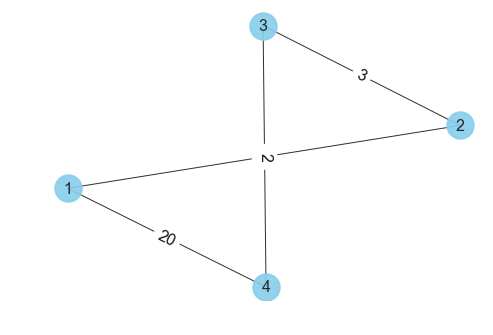

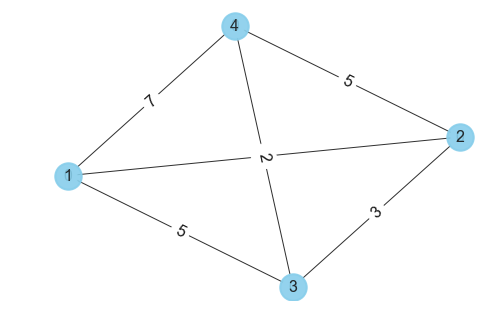

In [39]:
# Defining small example graph
G3 = nx.Graph()
G3.add_edge(1,2,weight=2)
G3.add_edge(2,3,weight=3)
G3.add_edge(3,4,weight=2)
G3.add_edge(1,4,weight=20)
G4= nx.Graph()
#Creation of the shortest path graph usign the  Floyd-transformation 
length=nx.floyd_warshall(G3, weight='weight') # It return a dictionary that has to be managed
for key1 in length.keys():
    for key2 in length[key1].keys():
        G4.add_edge(key1,key2,weight=length[key1][key2])
        
# Plotting of the inital graph
plt.figure(1)
labels=nx.get_edge_attributes(G3,'weight')
pos = graphviz_layout(G3, prog='neato')
nx.draw(G3,pos=pos,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9,font_size=16)
nx.draw_networkx_edge_labels(G3,pos,edge_labels=labels,font_size=16)

# Plotting of the transformed graph
plt.figure(2)
labels=nx.get_edge_attributes(G4,'weight')
pos = graphviz_layout(G4, prog='neato')
nx.draw(G4,pos=pos,with_labels = True,node_color="skyblue", linewidths=2,node_size=700,alpha=0.9,font_size=16)
nx.draw_networkx_edge_labels(G4,pos,edge_labels=labels,font_size=16)
print nx.adjacency_matrix(G4, weight='weight').todense() # Adjacency matrix considering also the weight

In [40]:
# Definition of the shortest path kernel taking in input the adjacency matrix of the Floyd-transformed graphlet
def shortestPathKernel(A1,A2):
    Az = np.kron(A1,A2)
    return Az.sum()

In [41]:
#declaring a new compute graphlet function that consider also the weight of the edges and directly return floyd-transformed graphlet
def computeGraphletWeighted(src,df):
    G1 = nx.Graph()
    for index, row in df[df.srcIP==src].iterrows():
        G1.add_edge(row["srcIP"], row["protocol"]+" ",weight=1)
        G1.add_edge(row["protocol"]+" ", " "+row["dstIP"],weight=1)
        G1.add_edge(" "+row["dstIP"], " "+row["sPort"]+" ",weight=1)
        G1.add_edge(" "+row["sPort"]+" ", "  "+row["dPort"]+"  ",weight=1)
        G1.add_edge("  "+row["dPort"]+"  ", "  "+row["dstIP"],weight=1)
    G2= nx.Graph()
    length=nx.floyd_warshall(G1, weight='weight')
    for key1 in length.keys():
        for key2 in length[key1].keys():
            G2.add_edge(key1,key2,weight=length[key1][key2])
    return G2

In [42]:
#declaring a new compute feature vector function that consider also the weight of the edges to create the adjacency matrix
def computeFeatureVector(walkLength,graphlet):
    a=nx.adjacency_matrix(graphlet,weight='weight',nodelist=sorted(graphlet.nodes())).todense()
    i=np.identity(a.shape[0], dtype = int )
    b=a
    res=i+a
    for i in range(1,walkLength):
        a=np.dot(a,b)
        res+=a
    return np.squeeze(np.asarray(res)).flatten()

In [43]:
# Shortest path kernel adapted for the SVM, so that will unpad the feature vector and reconstruct the adjacency matrix
def shortestPathKernel(Ax,Ay):
    res = []
    for i in range(len(Ax)):
        temp=[]
        A1 = Ax[i][Ax[i] != -1]
        A1 = A1.reshape(int(math.sqrt(A1.size)),int(math.sqrt(A1.size)))
        for j in range(len(Ay)):              
            A2 = Ay[j][Ay[j] != -1]            
            A2 = A2.reshape(int(math.sqrt(A2.size)),int(math.sqrt(A2.size)))
            Az = np.kron(A1,A2)
            temp.append(Az.sum())
        res.append(temp)
        print "Iteration: ",len(res)
    return res

In [44]:
# Building graphlets and feature vectorconsidering the weight of the edges
graphlets = []
Y=[]
features = []
maxlen=0
srcIP = list(dfClassified.srcIP.unique())
for i in range(len(srcIP)):
    graphlets.append(computeGraphletWeighted(srcIP[i],dfClassified))
    features.append(computeFeatureVector(1,graphlets[i]))
    if (len(features[i]) > maxlen):
            maxlen=len(features[i]) 
    if (hasAnomalies(srcIP[i],dfClassified)):
        Y.append("anomaly")
    else:
        Y.append("normal")
for i in range(len(srcIP)):
    features[i] = np.pad(features[i], (0,maxlen-features[i].size), 'constant', constant_values=(-1))

In [45]:
# Training of the model considering the firsts subsetsize entries
subsetSize= 50
clf = svm.SVC(gamma='auto',kernel=shortestPathKernel)
clf.fit(features[:subsetSize], Y[:subsetSize])

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto',
  kernel=<function shortestPathKernel at 0x120ad4848>, max_iter=-1,
  probability=False, random_state=None, shrinking=True, tol=0.001,
  verbose=False)

In [46]:
featuresUnclassified = []
graphlet=[]
dfUnclassified = pd.read_csv('not-annotated-trace.csv').astype(str) # Load unclassified graph
srcIP = list(dfUnclassified.srcIP.unique())
for i in range(len(srcIP)):
    graphlets.append(computeGraphletWeighted(srcIP[i],dfUnclassified)) # Obtaining all the graphlet
    featuresUnclassified.append(computeFeatureVector(4,graphlets[i])) # Building feature vector
for i in range(len(srcIP)):
    featuresUnclassified[i]=np.squeeze(np.resize(featuresUnclassified[i],(1,maxlen))) # padding with zeros

In [47]:
# Predicting with kernel trick, we are going to analyze few graphlet because computationally expensive
time_start = time.clock()
y_pred= clf.predict(featuresUnclassified[:subsetSize])
time_elapsed = (time.clock() - time_start)
print "Computation time: ", time_elapsed,"s"

Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Computation time:  102.77369 s
